<a href="https://colab.research.google.com/github/leorr/AI/blob/main/Projeto_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LINKS REFERÊNCIAS:

Classify Images Using Python & Machine Learning - https://www.youtube.com/watch?v=iGWbqhdjf2s

 CNN Com cachorros e gatos - https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

 what-are-max-pooling-average-pooling-global-max-pooling https://github.com/christianversloot/machine-learning-articles/blob/main/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling.md

 Global Max Pool https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D

Multiprocessing https://stackoverflow.com/questions/55531427/how-to-define-max-queue-size-workers-and-use-multiprocessing-in-keras-fit-gener

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os

# CONSTANTES

In [2]:
batch_size = 32 # Exemplos utilizados para um determinado processo
num_classes = 3 # classe de imagens possui 2 classes [Cachorros e Gatos]
dropout = 0.5 #rever
epochs = 500 #rever
lr = 0.001 #rever
IMG_HEIGHT = 64
IMG_WIDTH = 64

# Load model
Usamos softmax pois se espera "uma resposta correta"
https://stats.stackexchange.com/questions/233658/softmax-vs-sigmoid-function-in-logistic-classifier

In [3]:
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                  include_top=False,
                                                  drop_connect_rate=dropout,
                                                  pooling="max")
x=base_model.output
preds=tf.keras.layers.Dense(num_classes, activation='softmax')(x)       
model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=preds
)

In [4]:
for l in model.layers:
  if l.name.split('_')[0] != 'dense':
    l.trainable=False
  else:
    l.trainable=True

In [5]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input) #included in our dependencies
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
train_generator = train_data_gen.flow_from_directory('Downloads/archive/afhq/train',
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=True)
test_generator = train_data_gen.flow_from_directory('Downloads/archive/afhq/val',
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=True)
total=train_generator.n+test_generator.n
print(f"Porcentagem de data para teste: {((test_generator.n/total)*100):.2f}%")
print(f"Porcentagem de data para treino: {((train_generator.n/total)*100):.2f}%")

Found 6000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Porcentagem de data para teste: 20.00%
Porcentagem de data para treino: 80.00%


# Training model

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

history = model.fit(x=train_generator,
          steps_per_epoch=step_size_train,
          epochs=3,
          validation_data=test_generator,
          validation_steps=step_size_test,
          use_multiprocessing=False,
          )

Epoch 1/3
187/187 [==============================] - 27s 119ms/step - loss: 0.3671 - accuracy: 0.8592 - val_loss: 0.1957 - val_accuracy: 0.9395
Epoch 2/3
187/187 [==============================] - 21s 112ms/step - loss: 0.1931 - accuracy: 0.9300 - val_loss: 0.1592 - val_accuracy: 0.9463
Epoch 3/3
187/187 [==============================] - 21s 111ms/step - loss: 0.1709 - accuracy: 0.9383 - val_loss: 0.1435 - val_accuracy: 0.9504


In [7]:
results = model.evaluate_generator(test_generator, 15)
print('Acc: %.3f, Loss: %.3f' % (results[1], results[0]))
print(history.history.keys())

C:\Users\leona\AppData\Local\Temp\ipykernel_6804\2840589445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results = model.evaluate_generator(test_generator, 15)


Acc: 0.950, Loss: 0.142
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


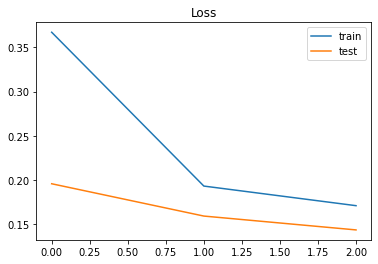

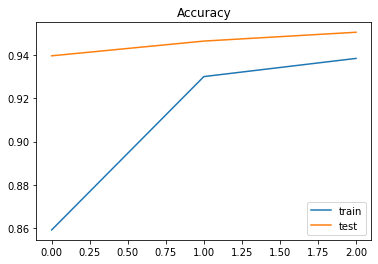

In [8]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
print()
print()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [11]:
predictions = model.predict(test_generator, steps = 10)
y_pred = (predictions > 0.5)
test_generator.ou
classification = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(classification)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(matrix, index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, linewidths=2.5)

10/10 [==============================] - 1s 88ms/step


TypeError: ignored